
**(1)** Testes de normalidade da série por três formas: histograma, curtose/assimetria, gráfico de quartis

**(2)** Avaliar se hipótese de normalidade vale para a série ou não.

In [1]:
library(dplyr)
library(tidyverse)
library(readxl)
library(mvtnorm)
library(fBasics)
library(ggplot2)
library(reshape)
library(forecast)
library(normtest)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1     v readr   1.3.1
v tibble  2.1.1     v purrr   0.3.2
v tidyr   0.8.3     v stringr 1.4.0
v ggplot2 3.1.1     v forcats 0.4.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'mvtnorm' was built under R version 3.6.3"Warning message:
"package 'fBasics' was built under R version 3.6.3"Loading required package: timeDate
Loading requi

In [19]:
summary_statistics = function(df){
    out_list = list()
    for (col in colnames(df)){
        loop_list = list()
        loop_df = df %>% select(col)
        for (stat_name in c('mean', 'skew', 'kurtosis')){
            if (stat_name == 'mean'){
                loop_list[stat_name] = mean(loop_df[,1], na.rm = TRUE)
            }
            else if (stat_name == 'skew'){
                loop_list[stat_name] = skewness(loop_df[,1], na.rm = TRUE)
            }
            else if (stat_name == 'kurtosis'){
                loop_list[stat_name] = kurtosis(loop_df[,1], na.rm = TRUE)
            }
        }
        out_list[[col]] = loop_list
    }
    return(out_list)
}

jarque_bera_test = function(series){
    out_list = list()
    for (s in 1:dim(series)[2]){
        jb_test = jb.norm.test(series[,s])
        out_list[[colnames(series)[s]]]['pval'] = jb_test$p.value
    }
    return(out_list)
}

In [3]:
df = read_excel('xr215smr.xls')
head(df, n = 13)

OBS,RENDMARK,RENDCYCO,RENDIT,RENDNCCO,RENDTEL
1980:01,7.2634484,6.0802285,-0.5366491,4.49443616,10.9634461
1980:02,6.3398955,-0.9241855,20.5049333,0.81392902,3.4031675
1980:03,-9.2852168,-3.2861743,9.2275332,-8.33387844,-9.7050646
1980:04,0.7932908,5.2119766,-0.9027138,0.61518101,-0.2652719
1980:05,-2.9024210,-16.1642111,-0.8388108,-5.10238748,-9.0053391
1980:06,8.6131509,-1.0547036,-0.8116578,12.25580033,9.4430618
1980:07,3.9820628,11.1723770,-0.8230116,3.55036306,12.3905677
1980:08,-1.1501709,-11.0632755,-0.8217404,-0.84902213,1.7987231
1980:09,3.4861259,-16.7769961,-0.7736204,-0.06932147,-5.5755250
1980:10,4.3298503,-7.0218340,-0.6249025,-3.20033524,0.4522192


In [4]:
target_df = df %>% select(RENDMARK, RENDCYCO, RENDIT, RENDNCCO, RENDTEL)
head(target_df)

RENDMARK,RENDCYCO,RENDIT,RENDNCCO,RENDTEL
7.2634484,6.0802285,-0.5366491,4.494436,10.9634461
6.3398955,-0.9241855,20.5049333,0.813929,3.4031675
-9.2852168,-3.2861743,9.2275332,-8.333878,-9.7050646
0.7932908,5.2119766,-0.9027138,0.615181,-0.2652719
-2.9024210,-16.1642111,-0.8388108,-5.102387,-9.0053391
8.6131509,-1.0547036,-0.8116578,12.255800,9.4430618


In [5]:
series = ts(target_df, start = c(1980, 1), frequency = 12)

### (1) Normality check

Assuming that the data was generated by a multivariate gaussian distribution, generate samples of it using the emprirical mean vector and covariance matrix and then estimate summary statistics from samples.

In [6]:
cov_matrix = cov(series) %>% as.matrix()
mean_vec = target_df %>% summarise_all(list(mean)) %>% as.numeric()

In [7]:
normal_samples = as.data.frame(rmvnorm(n = dim(target_df)[1], mean = mean_vec, sigma = cov_matrix))
colnames(normal_samples) = colnames(series)
normal_stat_list = summary_statistics(normal_samples)

No parametric assumtion, estimate summary statistics directly from empirical sample.

In [8]:
empirical_stat_list = summary_statistics(as.data.frame(target_df))

In [9]:
empirical_df = as.data.frame(target_df)
empirical_df['type'] = 'empirical'
normal_samples['type'] = 'normal'
hist_df = rbind(melt(empirical_df), melt(normal_samples))
head(hist_df)

Using type as id variables
Using type as id variables


type,variable,value
empirical,RENDMARK,7.2634484
empirical,RENDMARK,6.3398955
empirical,RENDMARK,-9.2852168
empirical,RENDMARK,0.7932908
empirical,RENDMARK,-2.9024210
empirical,RENDMARK,8.6131509


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


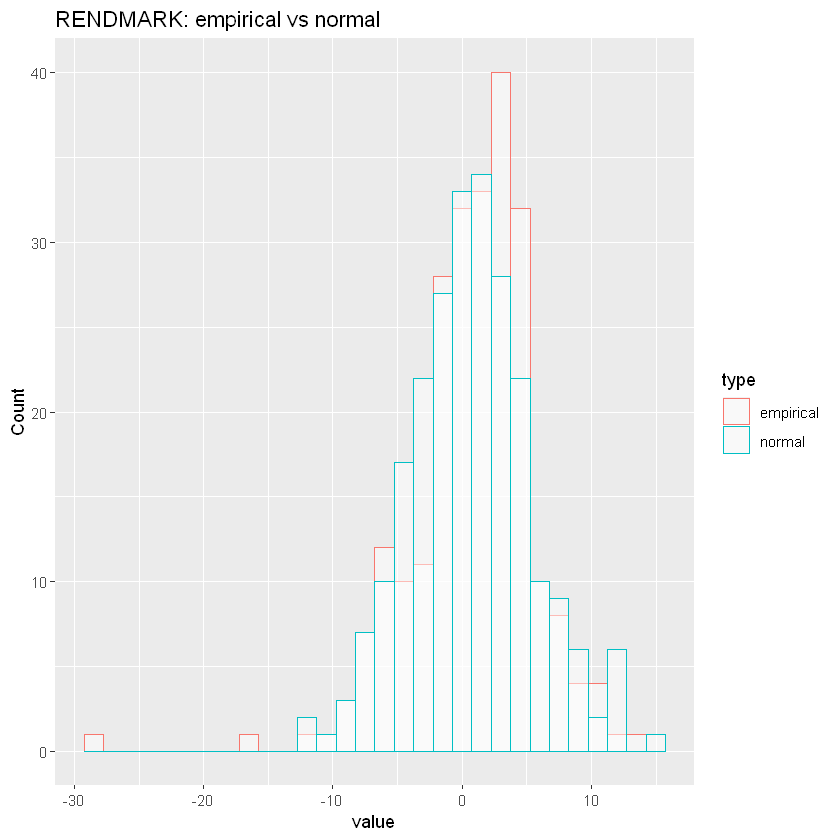

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


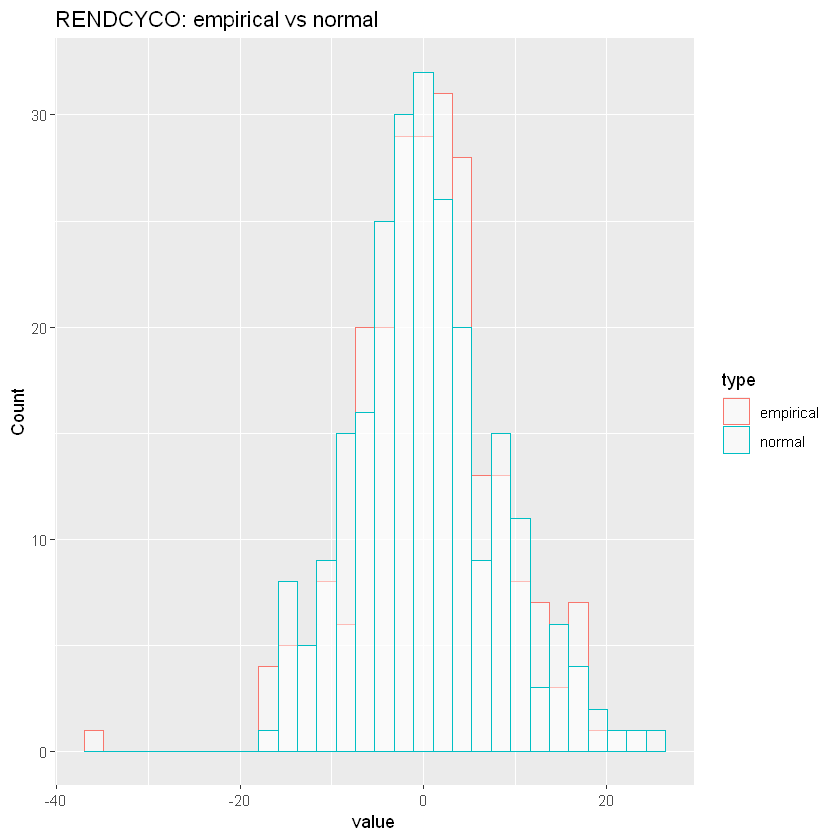

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


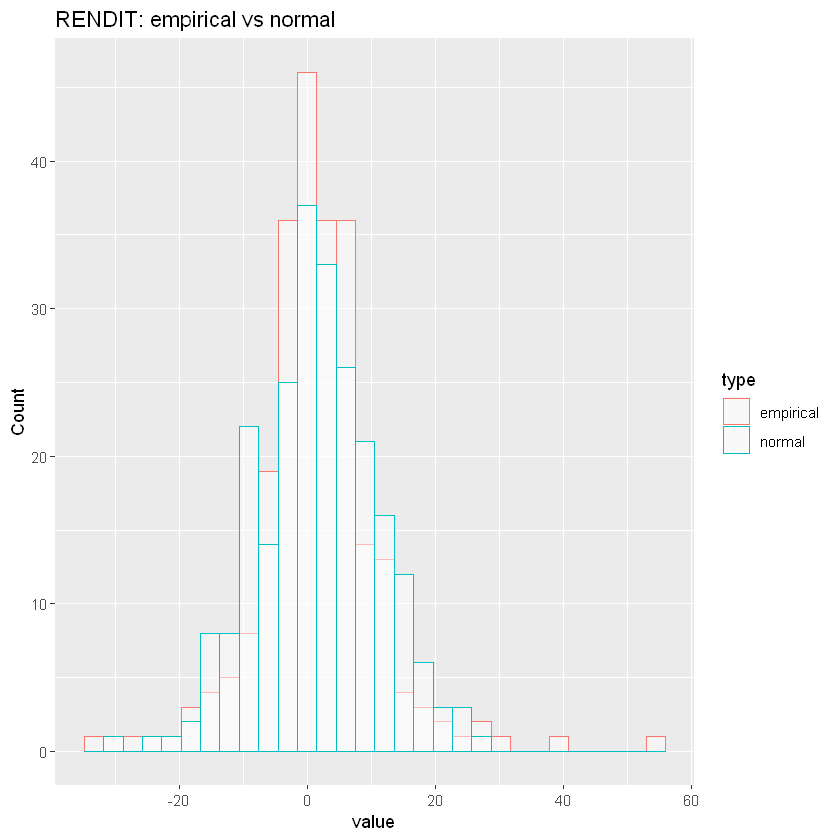

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


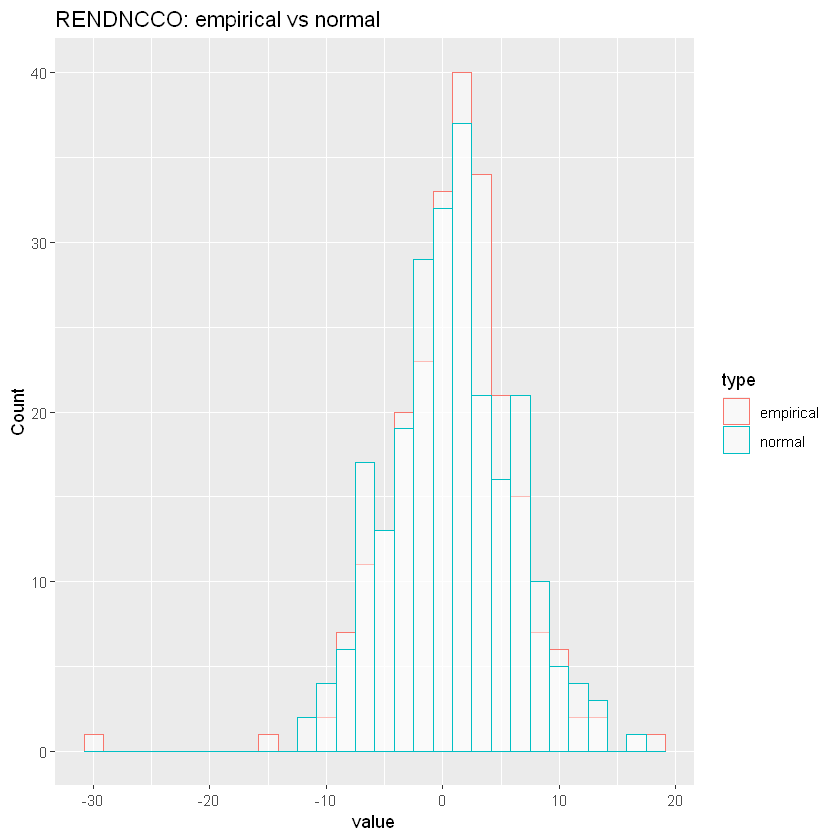

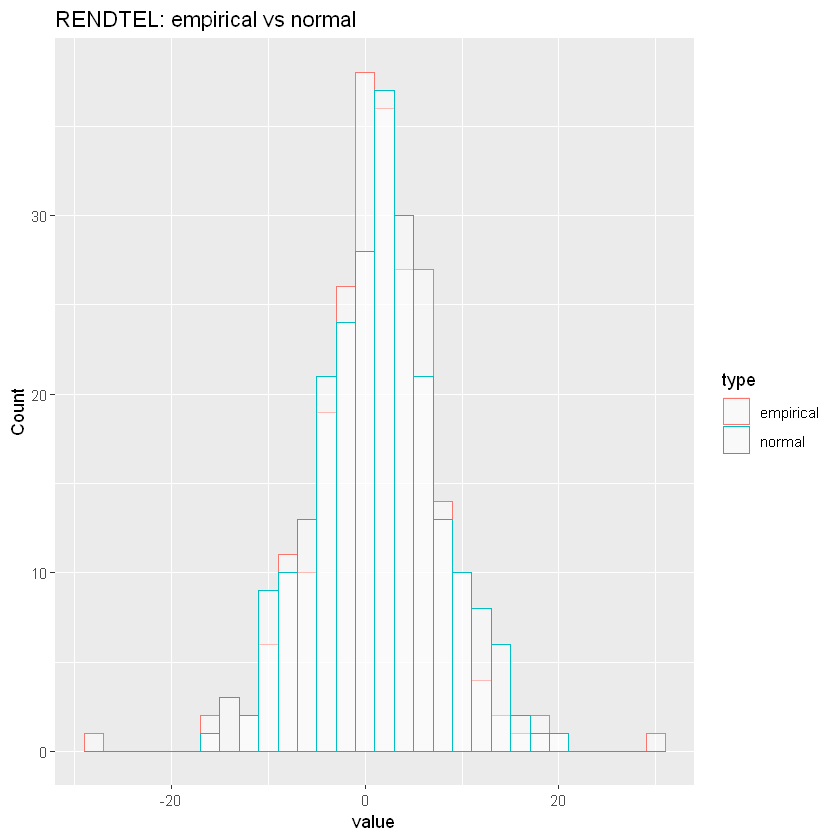

In [10]:
for (col in unique(hist_df[,2])){
    subset_df = hist_df %>% dplyr::filter(variable == col) %>% select(type, value)
    print(
        ggplot(subset_df, aes(x=value, color=type)) +
        geom_histogram(fill="white", alpha=0.5, position="identity") + 
        labs(title=paste0(col, ':',' ', 'empirical vs normal'), x = "value", y = "Count")
        )
}

In [11]:
summary_df = cbind(data.frame(unlist(normal_stat_list)), data.frame(unlist(empirical_stat_list)))
colnames(summary_df) = c('Fitted Normal', 'Empirical')
summary_df

,Fitted Normal,Empirical
RENDMARK.mean,0.66552737,0.80888397
RENDMARK.skew,0.17312127,-1.15057229
RENDMARK.kurtosis,0.27215190,5.30528631
RENDCYCO.mean,0.23431217,0.49982597
RENDCYCO.skew,0.42715962,-0.22945845
RENDCYCO.kurtosis,0.23467958,1.49391263
RENDIT.mean,1.64688821,1.32666751
RENDIT.skew,-0.10577498,0.57298196
RENDIT.kurtosis,0.18984448,4.85613799
RENDNCCO.mean,0.76446706,0.95138272


### **(2)** [Jarque and Bera (1980)](https://www.sciencedirect.com/science/article/abs/pii/0165176580900245) test for normality

Implemented using "normtest" package. The null hypothesis is a joint hypothesis of the skewness being zero and the excess kurtosis being zero.

In [20]:
pval_list = jarque_bera_test(series)

In [22]:
unlist(pval_list)

RENDMARK.pval RENDCYCO.pval   RENDIT.pval RENDNCCO.pval  RENDTEL.pval 
       0.0000        0.0015        0.0000        0.0000        0.0000